[View in Colaboratory](https://colab.research.google.com/github/manikanthM/fahion-mnist-/blob/master/variational_AE.ipynb)

In [0]:
import pandas as pd 
import keras 
from keras.datasets import fashion_mnist
from keras.models import load_model,Sequential,Model
from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.optimizers import SGD
from keras.layers import Dense, Input, Lambda, Layer, Add, Multiply
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
import matplotlib.pyplot as plt
import keras.backend as K
from scipy.misc import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

In [0]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

In [0]:
x_train=x_train/255
x_test=x_test/255

In [0]:
x_train=x_train.reshape(-1,784)
x_test=x_test.reshape(-1,784)

In [0]:
input_img=Input(shape=(784,))
encoded=Dense(300,activation='relu')(input_img)
z_mu=Dense(10)(encoded)
z_logsigma=Dense(10)(encoded)




In [0]:
class KLDivergenceLayer(Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_sigma = inputs

        kl_batch = - .5 * K.sum(1 + log_sigma -
                                K.square(mu) -
                                K.exp(log_sigma), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

z_mu, z_logsigma = KLDivergenceLayer()([z_mu, z_logsigma])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_logsigma)

eps = Input(tensor=K.random_normal(shape=(K.shape(input_img)[0],10)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])
  

In [0]:
decoder = Sequential([
    Dense(300, input_dim=10, activation='relu'),
    Dense(784, activation='sigmoid')
])


In [0]:
decoded=decoder(z)

In [0]:
autoencoder = Model([input_img, eps], decoded)

In [47]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 300)          235500      input_5[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 10)           3010        dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 10)           3010        dense_12[0][0]                   
__________________________________________________________________________________________________
kl_diverge

In [0]:
def nll(y_true, y_pred):
  return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [0]:
autoencoder.compile(optimizer='adam', loss=nll)
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')


In [52]:
train_history = autoencoder.fit(x_train, x_train, epochs=500, batch_size=2048, validation_data=(x_test, x_test), callbacks=[estop])
autoencoder.save('mymodel.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 7s 113us/step - loss: 441.3350 - val_loss: 356.8872
Epoch 2/500
60000/60000 [==============================] - 7s 119us/step - loss: 329.0771 - val_loss: 311.5986
Epoch 3/500
60000/60000 [==============================] - 7s 119us/step - loss: 300.3763 - val_loss: 292.0383
Epoch 4/500
60000/60000 [==============================] - 7s 119us/step - loss: 285.1070 - val_loss: 280.7912
Epoch 5/500
60000/60000 [==============================] - 7s 118us/step - loss: 276.7622 - val_loss: 275.0425
Epoch 6/500
60000/60000 [==============================] - 7s 118us/step - loss: 271.3717 - val_loss: 271.6019
Epoch 7/500
59392/60000 [============================>.] - ETA: 0s - loss: 267.9343

60000/60000 [==============================] - 7s 118us/step - loss: 267.9250 - val_loss: 267.7109
Epoch 8/500
60000/60000 [==============================] - 7s 117us/step - loss: 264.9681 - val_loss: 265.4549
Epoch 9/500
60000/60000 [==============================] - 7s 118us/step - loss: 262.9642 - val_loss: 263.5122
Epoch 10/500
60000/60000 [==============================] - 7s 118us/step - loss: 261.3453 - val_loss: 261.8555
Epoch 11/500
60000/60000 [==============================] - 7s 117us/step - loss: 259.7574 - val_loss: 261.6870
Epoch 12/500
60000/60000 [==============================] - 7s 118us/step - loss: 258.6648 - val_loss: 259.7736
Epoch 13/500
60000/60000 [==============================] - 7s 117us/step - loss: 257.4811 - val_loss: 258.5456
Epoch 14/500


60000/60000 [==============================] - 7s 117us/step - loss: 256.3332 - val_loss: 257.5112
Epoch 15/500
60000/60000 [==============================] - 7s 117us/step - loss: 255.7122 - val_loss: 256.7205
Epoch 16/500
60000/60000 [==============================] - 7s 117us/step - loss: 255.0020 - val_loss: 256.0146
Epoch 17/500
60000/60000 [==============================] - 7s 118us/step - loss: 254.2187 - val_loss: 255.5238
Epoch 18/500
60000/60000 [==============================] - 7s 118us/step - loss: 253.4704 - val_loss: 254.8294
Epoch 19/500
60000/60000 [==============================] - 7s 118us/step - loss: 253.0508 - val_loss: 254.9224
Epoch 20/500
60000/60000 [==============================] - 7s 118us/step - loss: 252.6412 - val_loss: 254.0589
Epoch 21/500
26624/60000 [============>.................] - ETA: 3s - loss: 252.1282

60000/60000 [==============================] - 7s 118us/step - loss: 251.9818 - val_loss: 253.3893
Epoch 22/500
60000/60000 [==============================] - 7s 118us/step - loss: 251.6004 - val_loss: 253.2936
Epoch 23/500
60000/60000 [==============================] - 7s 117us/step - loss: 251.1617 - val_loss: 252.5723
Epoch 24/500
60000/60000 [==============================] - 7s 117us/step - loss: 250.6850 - val_loss: 252.4655
Epoch 25/500
60000/60000 [==============================] - 7s 117us/step - loss: 250.4937 - val_loss: 253.2692
Epoch 26/500
60000/60000 [==============================] - 7s 117us/step - loss: 250.3852 - val_loss: 251.7582
Epoch 27/500
60000/60000 [==============================] - 7s 116us/step - loss: 249.8818 - val_loss: 251.3136
Epoch 28/500
28672/60000 [=============>................] - ETA: 3s - loss: 249.3262

60000/60000 [==============================] - 7s 117us/step - loss: 249.4093 - val_loss: 251.0167
Epoch 29/500
60000/60000 [==============================] - 7s 116us/step - loss: 249.1277 - val_loss: 250.7392
Epoch 30/500
60000/60000 [==============================] - 7s 117us/step - loss: 248.8945 - val_loss: 250.4281
Epoch 31/500
60000/60000 [==============================] - 7s 116us/step - loss: 248.7418 - val_loss: 250.3077
Epoch 32/500
60000/60000 [==============================] - 7s 117us/step - loss: 248.7470 - val_loss: 250.7042
Epoch 33/500
60000/60000 [==============================] - 7s 118us/step - loss: 248.4313 - val_loss: 249.8373
Epoch 34/500
60000/60000 [==============================] - 7s 116us/step - loss: 247.9971 - val_loss: 249.5932
Epoch 35/500
28672/60000 [=============>................] - ETA: 3s - loss: 247.8161

60000/60000 [==============================] - 7s 116us/step - loss: 247.8604 - val_loss: 249.3838
Epoch 36/500
60000/60000 [==============================] - 7s 117us/step - loss: 247.6679 - val_loss: 249.2463
Epoch 37/500
60000/60000 [==============================] - 7s 117us/step - loss: 247.7166 - val_loss: 249.1985
Epoch 38/500
60000/60000 [==============================] - 7s 117us/step - loss: 247.2619 - val_loss: 248.8703
Epoch 39/500
60000/60000 [==============================] - 7s 116us/step - loss: 247.1550 - val_loss: 248.7365
Epoch 40/500
60000/60000 [==============================] - 7s 116us/step - loss: 247.0228 - val_loss: 248.5554
Epoch 41/500
60000/60000 [==============================] - 7s 116us/step - loss: 246.8384 - val_loss: 249.4648
Epoch 42/500
28672/60000 [=============>................] - ETA: 3s - loss: 246.5876

60000/60000 [==============================] - 7s 117us/step - loss: 246.8191 - val_loss: 248.3832
Epoch 43/500
60000/60000 [==============================] - 7s 117us/step - loss: 246.8471 - val_loss: 248.6196
Epoch 44/500
60000/60000 [==============================] - 7s 117us/step - loss: 246.4322 - val_loss: 248.0758
Epoch 45/500
60000/60000 [==============================] - 7s 117us/step - loss: 246.2177 - val_loss: 247.9502
Epoch 46/500
60000/60000 [==============================] - 7s 117us/step - loss: 246.1488 - val_loss: 247.8144
Epoch 47/500
60000/60000 [==============================] - 7s 117us/step - loss: 246.1977 - val_loss: 247.8481
Epoch 48/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.9115 - val_loss: 247.5360
Epoch 49/500
28672/60000 [=============>................] - ETA: 3s - loss: 245.2600

60000/60000 [==============================] - 7s 117us/step - loss: 245.7678 - val_loss: 247.4113
Epoch 50/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.5718 - val_loss: 247.7229
Epoch 51/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.5858 - val_loss: 247.2638
Epoch 52/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.3821 - val_loss: 247.2174
Epoch 53/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.3508 - val_loss: 247.1398
Epoch 54/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.4539 - val_loss: 247.0079
Epoch 55/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.1272 - val_loss: 247.0987
Epoch 56/500
28672/60000 [=============>................] - ETA: 3s - loss: 245.2845

60000/60000 [==============================] - 7s 117us/step - loss: 245.0675 - val_loss: 246.7729
Epoch 57/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.9675 - val_loss: 246.6496
Epoch 58/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.8502 - val_loss: 246.6929
Epoch 59/500
60000/60000 [==============================] - 7s 117us/step - loss: 245.0071 - val_loss: 246.6023
Epoch 60/500
60000/60000 [==============================] - 7s 116us/step - loss: 244.7347 - val_loss: 246.9376
Epoch 61/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.6086 - val_loss: 246.5948
Epoch 62/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.6241 - val_loss: 246.2793
Epoch 63/500
28672/60000 [=============>................] - ETA: 3s - loss: 244.4684

60000/60000 [==============================] - 7s 117us/step - loss: 244.3923 - val_loss: 246.3859
Epoch 64/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.3018 - val_loss: 246.1626
Epoch 65/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.3844 - val_loss: 246.3010
Epoch 66/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.2544 - val_loss: 246.1819
Epoch 67/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.1299 - val_loss: 246.3518
Epoch 68/500
60000/60000 [==============================] - 7s 117us/step - loss: 244.1116 - val_loss: 245.8512
Epoch 69/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.9770 - val_loss: 245.9926
Epoch 70/500
28672/60000 [=============>................] - ETA: 3s - loss: 243.8279

60000/60000 [==============================] - 7s 116us/step - loss: 243.9629 - val_loss: 245.7769
Epoch 71/500
60000/60000 [==============================] - 7s 117us/step - loss: 243.9501 - val_loss: 246.2219
Epoch 72/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.9534 - val_loss: 245.7905
Epoch 73/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.7760 - val_loss: 245.5654
Epoch 74/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.6283 - val_loss: 245.4159
Epoch 75/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.5851 - val_loss: 245.4235
Epoch 76/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.6726 - val_loss: 245.5318
Epoch 77/500
28672/60000 [=============>................] - ETA: 3s - loss: 243.7622

60000/60000 [==============================] - 7s 117us/step - loss: 243.4788 - val_loss: 245.7804
Epoch 78/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.4497 - val_loss: 245.6632
Epoch 79/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.3091 - val_loss: 245.2887
Epoch 80/500
60000/60000 [==============================] - 7s 117us/step - loss: 243.3629 - val_loss: 245.3111
Epoch 81/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.3100 - val_loss: 245.1349
Epoch 82/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.4449 - val_loss: 245.0599
Epoch 83/500
60000/60000 [==============================] - 7s 116us/step - loss: 243.1113 - val_loss: 245.3771
Epoch 84/500
28672/60000 [=============>................] - ETA: 3s - loss: 243.4269

60000/60000 [==============================] - 7s 116us/step - loss: 243.4343 - val_loss: 245.0472
Epoch 85/500
60000/60000 [==============================] - 7s 117us/step - loss: 243.0913 - val_loss: 244.8954
Epoch 86/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.9280 - val_loss: 244.8869
Epoch 87/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.9562 - val_loss: 244.7348
Epoch 88/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.9433 - val_loss: 245.4517
Epoch 89/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.8485 - val_loss: 244.7482
Epoch 90/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.9841 - val_loss: 244.7930
Epoch 91/500
28672/60000 [=============>................] - ETA: 3s - loss: 242.9114

60000/60000 [==============================] - 7s 116us/step - loss: 242.8935 - val_loss: 244.6353
Epoch 92/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.6459 - val_loss: 244.6616
Epoch 93/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.5883 - val_loss: 244.7042
Epoch 94/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.5838 - val_loss: 244.6819
Epoch 95/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.5626 - val_loss: 244.4785
Epoch 96/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.5318 - val_loss: 244.6157
Epoch 97/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.4194 - val_loss: 244.3818
Epoch 98/500
28672/60000 [=============>................] - ETA: 3s - loss: 242.7678

60000/60000 [==============================] - 7s 117us/step - loss: 242.3911 - val_loss: 244.4060
Epoch 99/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.5065 - val_loss: 244.4952
Epoch 100/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.3418 - val_loss: 244.2931
Epoch 101/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.4321 - val_loss: 245.0055
Epoch 102/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.5935 - val_loss: 244.4714
Epoch 103/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.2555 - val_loss: 244.3517
Epoch 104/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.2397 - val_loss: 244.3578
Epoch 105/500
26624/60000 [============>.................] - ETA: 3s - loss: 242.2396

60000/60000 [==============================] - 7s 117us/step - loss: 242.1101 - val_loss: 244.1379
Epoch 106/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.1169 - val_loss: 244.7230
Epoch 107/500
60000/60000 [==============================] - 7s 116us/step - loss: 242.1391 - val_loss: 244.1323
Epoch 108/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.9870 - val_loss: 244.0005
Epoch 109/500
60000/60000 [==============================] - 7s 117us/step - loss: 242.0978 - val_loss: 243.9581
Epoch 110/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.9506 - val_loss: 244.1850
Epoch 111/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.8435 - val_loss: 244.0690
Epoch 112/500
26624/60000 [============>.................] - ETA: 3s - loss: 241.9375

60000/60000 [==============================] - 7s 117us/step - loss: 242.0440 - val_loss: 243.8971
Epoch 113/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.8928 - val_loss: 243.7453
Epoch 114/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.7668 - val_loss: 243.7389
Epoch 115/500
60000/60000 [==============================] - 7s 116us/step - loss: 241.9635 - val_loss: 243.8381
Epoch 116/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.7102 - val_loss: 243.8003
Epoch 117/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.6968 - val_loss: 243.5541
Epoch 118/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.7405 - val_loss: 244.1571
Epoch 119/500
26624/60000 [============>.................] - ETA: 3s - loss: 241.8978

60000/60000 [==============================] - 7s 117us/step - loss: 241.6688 - val_loss: 243.5650
Epoch 120/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.6830 - val_loss: 243.6183
Epoch 121/500
60000/60000 [==============================] - 7s 116us/step - loss: 241.5883 - val_loss: 243.6267
Epoch 122/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.6098 - val_loss: 244.0771
Epoch 123/500
60000/60000 [==============================] - 7s 116us/step - loss: 241.6426 - val_loss: 243.5915
Epoch 124/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.7105 - val_loss: 243.5145
Epoch 125/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.4725 - val_loss: 243.5241
Epoch 126/500
26624/60000 [============>.................] - ETA: 3s - loss: 241.6340

60000/60000 [==============================] - 7s 118us/step - loss: 241.5347 - val_loss: 243.6179
Epoch 127/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.4035 - val_loss: 243.4507
Epoch 128/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.5806 - val_loss: 243.4806
Epoch 129/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.3424 - val_loss: 243.4359
Epoch 130/500
60000/60000 [==============================] - 7s 117us/step - loss: 241.2998 - val_loss: 243.3296
Epoch 131/500
60000/60000 [==============================] - 7s 110us/step - loss: 241.4134 - val_loss: 243.9415
Epoch 132/500
60000/60000 [==============================] - 5s 82us/step - loss: 241.3316 - val_loss: 243.2425
Epoch 133/500
28672/60000 [=============>................] - ETA: 2s - loss: 241.3289

60000/60000 [==============================] - 5s 81us/step - loss: 241.2077 - val_loss: 243.4105
Epoch 134/500
60000/60000 [==============================] - 5s 82us/step - loss: 241.2213 - val_loss: 243.3591
Epoch 135/500
60000/60000 [==============================] - 5s 82us/step - loss: 241.2498 - val_loss: 243.1890
Epoch 136/500
60000/60000 [==============================] - 5s 84us/step - loss: 241.1968 - val_loss: 243.6133
Epoch 137/500
60000/60000 [==============================] - 5s 83us/step - loss: 241.4490 - val_loss: 243.1955
Epoch 138/500
60000/60000 [==============================] - 5s 84us/step - loss: 241.1009 - val_loss: 243.1956
Epoch 139/500
60000/60000 [==============================] - 5s 84us/step - loss: 241.1229 - val_loss: 243.2913
Epoch 140/500
34816/60000 [================>.............] - ETA: 1s - loss: 241.1702

60000/60000 [==============================] - 5s 84us/step - loss: 241.0261 - val_loss: 243.0568
Epoch 141/500
60000/60000 [==============================] - 5s 84us/step - loss: 241.0769 - val_loss: 243.1108
Epoch 142/500
60000/60000 [==============================] - 5s 83us/step - loss: 241.1421 - val_loss: 242.9675
Epoch 143/500
60000/60000 [==============================] - 5s 83us/step - loss: 240.9760 - val_loss: 243.1676
Epoch 144/500
60000/60000 [==============================] - 5s 83us/step - loss: 240.9490 - val_loss: 242.9434
Epoch 145/500
60000/60000 [==============================] - 5s 83us/step - loss: 240.9863 - val_loss: 243.4067
Epoch 146/500
60000/60000 [==============================] - 5s 82us/step - loss: 241.2061 - val_loss: 242.9594
Epoch 147/500
36864/60000 [=================>............] - ETA: 1s - loss: 240.7794

60000/60000 [==============================] - 5s 81us/step - loss: 241.0022 - val_loss: 242.8391
Epoch 148/500
60000/60000 [==============================] - 5s 81us/step - loss: 240.8173 - val_loss: 243.0882
Epoch 149/500
60000/60000 [==============================] - 5s 81us/step - loss: 240.9154 - val_loss: 242.8980
Epoch 150/500
60000/60000 [==============================] - 5s 80us/step - loss: 240.7882 - val_loss: 242.8255
Epoch 151/500
60000/60000 [==============================] - 5s 79us/step - loss: 240.8052 - val_loss: 242.9822
Epoch 152/500
60000/60000 [==============================] - 5s 88us/step - loss: 240.8348 - val_loss: 242.9863
Epoch 153/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.8764 - val_loss: 243.3074
Epoch 154/500
32768/60000 [===============>..............] - ETA: 3s - loss: 240.6556

60000/60000 [==============================] - 7s 117us/step - loss: 240.8261 - val_loss: 243.0710
Epoch 155/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.6886 - val_loss: 242.6331
Epoch 156/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.6315 - val_loss: 242.6912
Epoch 157/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.6950 - val_loss: 242.8448
Epoch 158/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.8524 - val_loss: 242.7400
Epoch 159/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.6436 - val_loss: 242.7391
Epoch 160/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.7007 - val_loss: 242.8354
Epoch 161/500
26624/60000 [============>.................] - ETA: 3s - loss: 240.7329

60000/60000 [==============================] - 7s 116us/step - loss: 240.5919 - val_loss: 242.5869
Epoch 162/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.6290 - val_loss: 242.7651
Epoch 163/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.5853 - val_loss: 242.5756
Epoch 164/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.4528 - val_loss: 242.8982
Epoch 165/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.5288 - val_loss: 243.2612
Epoch 166/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.6160 - val_loss: 242.5109
Epoch 167/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.4317 - val_loss: 242.4947
Epoch 168/500
26624/60000 [============>.................] - ETA: 3s - loss: 240.4844

60000/60000 [==============================] - 7s 117us/step - loss: 240.6694 - val_loss: 242.8251
Epoch 169/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.5504 - val_loss: 242.6798
Epoch 170/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.3691 - val_loss: 242.4296
Epoch 171/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.4065 - val_loss: 242.5898
Epoch 172/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.3773 - val_loss: 242.6994
Epoch 173/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.5222 - val_loss: 242.6257
Epoch 174/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.3006 - val_loss: 242.3879
Epoch 175/500
26624/60000 [============>.................] - ETA: 3s - loss: 240.3359

60000/60000 [==============================] - 7s 117us/step - loss: 240.3792 - val_loss: 242.4795
Epoch 176/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.3253 - val_loss: 242.5434
Epoch 177/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.3411 - val_loss: 242.3256
Epoch 178/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.2893 - val_loss: 242.5859
Epoch 179/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.3386 - val_loss: 242.7131
Epoch 180/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.3063 - val_loss: 242.2493
Epoch 181/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.1734 - val_loss: 243.1280
Epoch 182/500
26624/60000 [============>.................] - ETA: 3s - loss: 240.2721

60000/60000 [==============================] - 7s 116us/step - loss: 240.3685 - val_loss: 242.2693
Epoch 183/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.2608 - val_loss: 242.2480
Epoch 184/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.1764 - val_loss: 242.6692
Epoch 185/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.2588 - val_loss: 242.1549
Epoch 186/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.1645 - val_loss: 242.2045
Epoch 187/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.1781 - val_loss: 242.3336
Epoch 188/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.0963 - val_loss: 242.2674
Epoch 189/500
26624/60000 [============>.................] - ETA: 3s - loss: 240.1060

60000/60000 [==============================] - 7s 116us/step - loss: 240.0242 - val_loss: 242.4769
Epoch 190/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.1531 - val_loss: 242.1550
Epoch 191/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.1076 - val_loss: 242.1198
Epoch 192/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.0389 - val_loss: 243.0940
Epoch 193/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.1564 - val_loss: 242.2228
Epoch 194/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.0399 - val_loss: 242.0442
Epoch 195/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.0748 - val_loss: 242.1033
Epoch 196/500
26624/60000 [============>.................] - ETA: 3s - loss: 239.7214

60000/60000 [==============================] - 7s 116us/step - loss: 240.0385 - val_loss: 242.1639
Epoch 197/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.0343 - val_loss: 242.4636
Epoch 198/500
60000/60000 [==============================] - 7s 117us/step - loss: 240.0586 - val_loss: 242.3990
Epoch 199/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.0648 - val_loss: 242.2125
Epoch 200/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.9457 - val_loss: 242.3446
Epoch 201/500
60000/60000 [==============================] - 7s 116us/step - loss: 240.0584 - val_loss: 241.9544
Epoch 202/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.9522 - val_loss: 242.4555
Epoch 203/500
26624/60000 [============>.................] - ETA: 3s - loss: 240.4215

60000/60000 [==============================] - 7s 115us/step - loss: 240.0663 - val_loss: 242.2213
Epoch 204/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.9680 - val_loss: 242.0175
Epoch 205/500
60000/60000 [==============================] - 7s 118us/step - loss: 239.8796 - val_loss: 242.0576
Epoch 206/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.8632 - val_loss: 242.3150
Epoch 207/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.8730 - val_loss: 241.8403
Epoch 208/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.7481 - val_loss: 242.1183
Epoch 209/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.8467 - val_loss: 242.0317
Epoch 210/500
26624/60000 [============>.................] - ETA: 3s - loss: 239.4168

60000/60000 [==============================] - 7s 116us/step - loss: 239.8429 - val_loss: 241.9608
Epoch 211/500
60000/60000 [==============================] - 7s 117us/step - loss: 239.8347 - val_loss: 241.8450
Epoch 212/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.8161 - val_loss: 241.8846
Epoch 213/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.9063 - val_loss: 241.9704
Epoch 214/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.6908 - val_loss: 241.8960
Epoch 215/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.7286 - val_loss: 242.2110
Epoch 216/500
60000/60000 [==============================] - 7s 116us/step - loss: 239.7765 - val_loss: 241.8928
Epoch 217/500
26624/60000 [============>.................] - ETA: 3s - loss: 240.1752

60000/60000 [==============================] - 7s 117us/step - loss: 239.6862 - val_loss: 241.8622
Epoch 00217: early stopping


In [0]:
pred = autoencoder.predict(x_test)

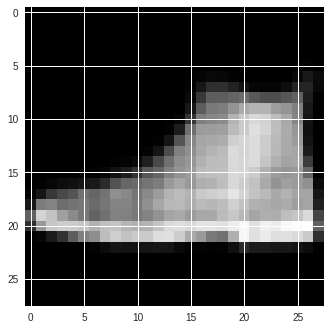

In [55]:
plt.imshow(pred[0].reshape(28, 28), cmap='gray')

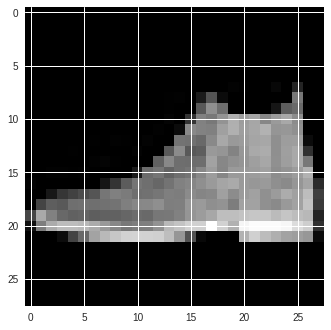

In [56]:
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')

In [0]:
def rms(x,y):
  a=(x^2-y^2)
  return a

In [0]:
score=autoencoder.evaluate(pred,y_test,verbose=0)
